## Price Predictions Bayesian Neural Networks - Oliver Dobbs


### Import Packages

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

import yfinance as yf

plt.rcParams.update({'figure.figsize':(13,10)})
plt.rcParams.update({'font.size':20})

## Input Stock Ticker or Comodity

In [2]:
ticker = "SPY" #"BTC-USD" #"AAPL" #"NFLX"

### Extract Price Information From Yahoo Finance

In [3]:
ticker_y = yf.Ticker(ticker)
df = ticker_y.history(period="5y")

In [4]:
df.reset_index(inplace=True)

In [5]:
series=df.Close

### Definitions

In [6]:
window_size = 21
def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [7]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [8]:
def pred_stock_future(X_test,
                                           future_length,
                                           sample_nbr=10):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [9]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

## Analysis on Price

In [10]:
#Create Window Size after which the prediction will start
window_size = 21

#scaling and selecting data
close_prices = df['Close']
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df['Close']

In [11]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

/var/folders/w5/d0_t8_nn0hl7thn0bzzlyk000000gn/T/ipykernel_65165/1172854888.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  features = torch.tensor(time_stamps[timestep_size:]).float()


In [12]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 1.0523
Iteration: 500 Val-loss: 0.6321
Iteration: 750 Val-loss: 0.4808
Iteration: 1000 Val-loss: 0.3588


In [13]:
#pred_unscaled
original = close_prices_unscaled[1:][window_size:]

In [14]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [15]:
future_length=7
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [16]:
c=len(upper_bound_unscaled)

### Calculate the proportion of predictions in the confidence interval

In [17]:
y = np.array(df.Close[-c:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)
price_acc = np.mean(total)
print("{} of test price is in our confidence interval".format(round(price_acc,2)))

0.12 of test price is in our confidence interval


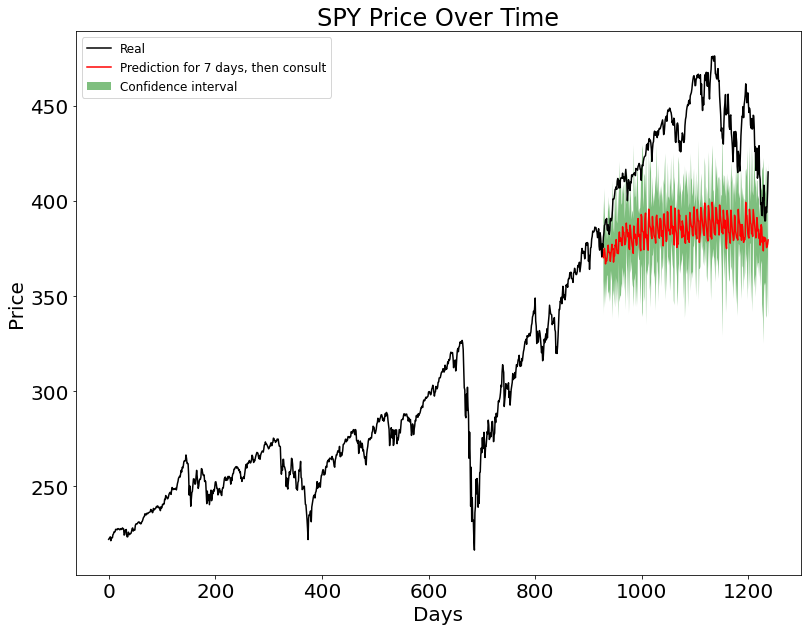

In [18]:
plt.title(ticker + " Price Over Time", color="black")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc="upper left",prop={'size': 12})

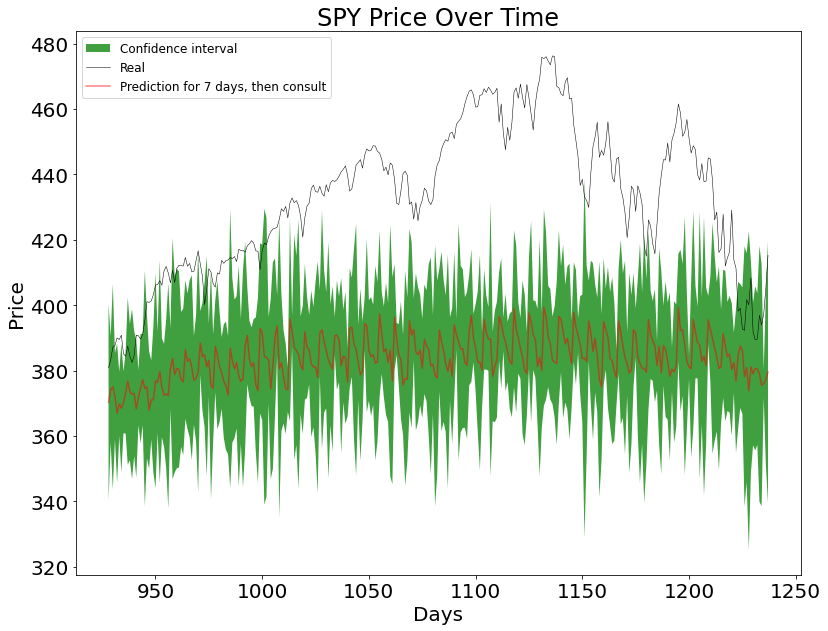

In [19]:
plt.title(ticker + " Price Over Time", color="black")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red",
         alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc="upper left",prop={'size': 12})

## Analysis on Detrend Price

In general prices of stocks tend to follow an upwards trend. Neural Networks do not predict upwards trending stocks very well. This is because the model will not predict a higher price than what is seen in the training data. Therefor to get around this we can detrend the data and analyze the deviations from that trend.

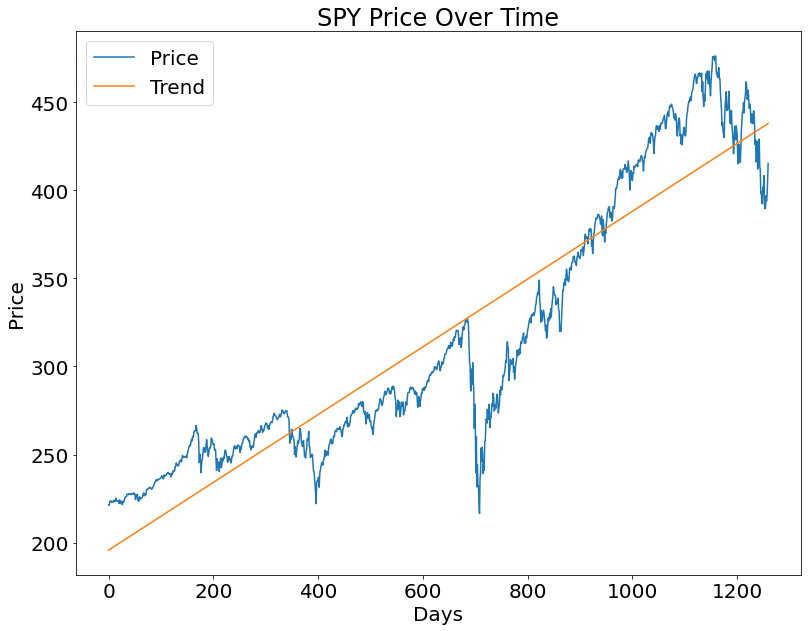

In [20]:
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values

## Conduct a linear regression on the price.
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

## Detrend the data by subtracting the price form the linear regression
detrended = [y[i]-trend[i] for i in range(0, len(series))]

## Plot trend and price over time
plt.plot(y, label ="Price")
plt.plot(trend, label ="Trend")
plt.legend(loc="upper left")
plt.title(ticker + " Price Over Time", color="black")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

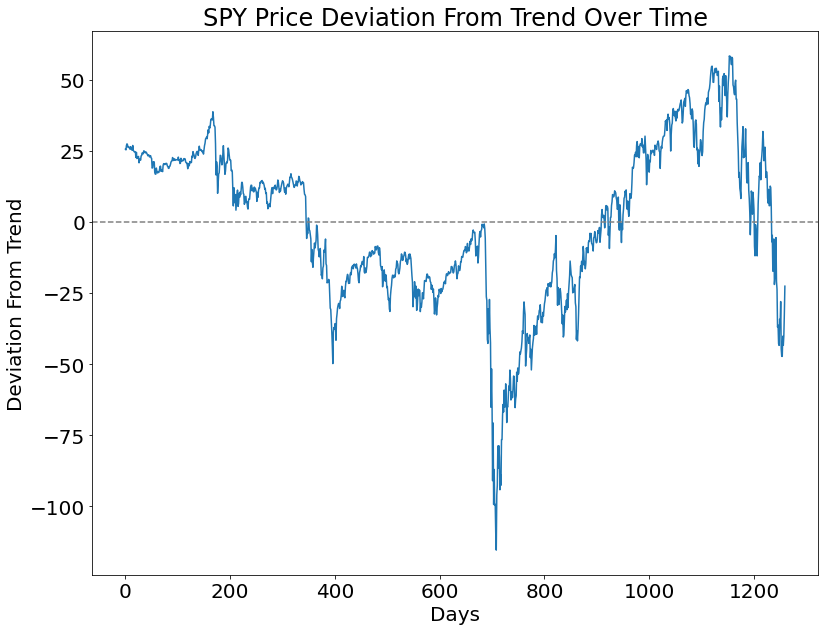

In [21]:
plt.title(ticker + " Price Deviation From Trend Over Time", color="black")
plt.xlabel('Days')
plt.ylabel('Deviation From Trend')
plt.plot(detrended)
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()

In [22]:
df['Close']=detrended

### Conduct Bayesian Neural Networks with LSTM Architecture

In [23]:
#Create Window Size after which the prediction will start
window_size = 21

#scaling and selecting data
close_prices = df['Close']
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df['Close']

In [24]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [25]:
len(ys)

1238

In [26]:
len(Xs)

1238

In [27]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.4364
Iteration: 500 Val-loss: 0.2163
Iteration: 750 Val-loss: 0.2204
Iteration: 1000 Val-loss: 0.1650


In [28]:
#pred_unscaled
original = close_prices_unscaled[1:][window_size:]

In [29]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [30]:
future_length=7
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [31]:
c=len(upper_bound_unscaled)

### Calculate the proportion of predictions in the confidence interval

In [32]:
y = np.array(df.Close[-c:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)
detrended_acc = np.mean(total)
print("{} of test detrended price is in our confidence interval".format(round(detrended_acc,2)))

0.41 of test detrended price is in our confidence interval


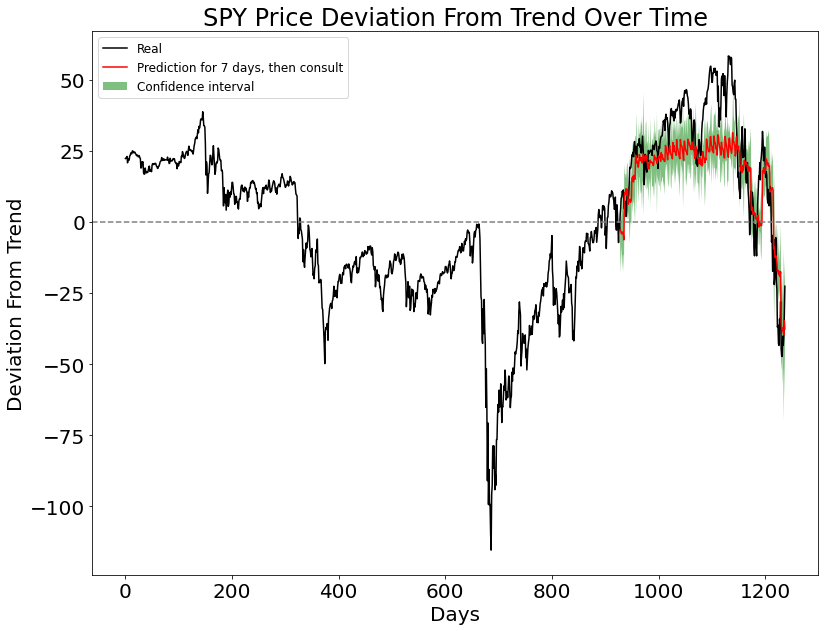

In [33]:
plt.title(ticker + " Price Deviation From Trend Over Time", color="black")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Deviation From Trend')
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc="upper left",prop={'size': 12})

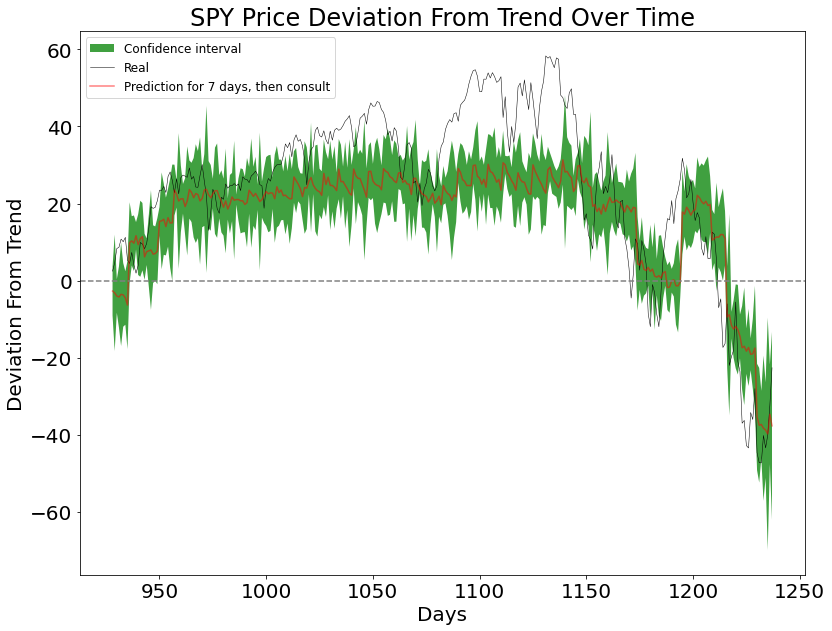

In [34]:
plt.title(ticker + " Price Deviation From Trend Over Time", color="black")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red",
         alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Deviation From Trend')
plt.legend(loc="upper left",prop={'size': 12})
plt.axhline(y=0, color='grey', linestyle='--')

## Comparison

In [35]:
print("{} of test price is in our confidence interval for normal price".format(round(price_acc,2)))
print("{} of test price is in our confidence interval for detrended price".format(round(detrended_acc,2)))
print("Detrended has {} more of test price in our confidence interval compared to normal price".format(round(detrended_acc-price_acc,2)))

0.12 of test price is in our confidence interval for normal price
0.41 of test price is in our confidence interval for detrended price
Detrended has 0.29 more of test price in our confidence interval compared to normal price


## References

I would like to thank Piero Esposito for creating the Blitz module. I would also like to thank him for his conversations on this project and his base code for conducting Bayesian Learning for Stock Market Predictions.

@misc{esposito2020blitzbdl,
author = {Piero Esposito},
    title = {BLiTZ - Bayesian Layers in Torch Zoo (a Bayesian Deep Learing library for Torch)},
    year = {2020},
    publisher = {GitHub},
    journal = {GitHub repository},
    howpublished = {\url{https://github.com/piEsposito/blitz-bayesian-deep-learning/}},
}